## *MScBA BA&M 23*: FinTech MVP- NSure's ML Classifier Model Development
> Project author: Oleksii Grygoryshyn \
> Student ID: 528646 \
> Date: 23/06/23

#### Loading in necessary Libraries, Packages, and Datasets

In this section, the required libraries and packages used for the development of the classifier model are installed. The dataset containing 1,800 simulated samples for training (and testing) of the model is also loaded into the session. The dataset was simulated by generating values using unique normal and binomial distributions for features of every seperate insurance plan covered by the model (18 insurance products).

In [1]:
# Installing necessary Libraries, Packages, and Functions
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="dark")

from sklearn.ensemble import (
    RandomForestClassifier
)
from sklearn.model_selection import (
    cross_validate,
    train_test_split
)
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

pd.set_option('display.float_format', lambda x: f'{x:.3f}')

import pickle

In [2]:
# Loading Pre-processed df_clean
df_clean = pd.read_csv("NSure_Data.csv", delimiter=";")

df_clean

,Insurance_plan,CPM,P_term,Healthcare_cover,NC_reimbursement,Bundle_options,Dental_options,Physio_term,Mental_health_options,International_cover
0,United Customers: Conscious Choice,127.450,Monthly,Wide,60,Limited,No,No,No,Limited
1,United Customers: Conscious Choice,128.000,Monthly,Limited,61,Limited,No,Yes,No,Limited
2,United Customers: Conscious Choice,130.000,Monthly,Wide,60,Limited,No,Yes,No,Limited
3,United Customers: Conscious Choice,127.000,Monthly,Unlimited,59,Wide,No,Yes,No,Yes
4,United Customers: Conscious Choice,123.000,Monthly,Unlimited,61,Wide,No,No,No,Limited
...,...,...,...,...,...,...,...,...,...,...
1795,FTBO Base Free,143.000,Yearly,Unlimited,99,Wide,No,No,No,Limited
1796,FTBO Base Free,140.000,Monthly,Unlimited,100,Wide,No,No,No,Yes
1797,FTBO Base Free,141.000,Monthly,Unlimited,100,Wide,No,No,No,Yes
1798,FTBO Base Free,139.000,Yearly,Unlimited,100,Wide,No,No,No,Yes


#### Pre-processing

During preprocessing, the features of the dataset get correctly assigned to their data types.

In [3]:
# Converting columns into correct data type formats
df_clean[["NC_reimbursement"]] = df_clean[["NC_reimbursement"]].astype(int)

df_clean[["CPM"]] = df_clean[["CPM"]].astype(float)

df_clean[
    [
        "Insurance_plan",
        "P_term",
        "Healthcare_cover",
        "Bundle_options",
        "Dental_options",
        "Physio_term",
        "Mental_health_options",
        "International_cover",
    ]
] = df_clean[
    [
        "Insurance_plan",
        "P_term",
        "Healthcare_cover",
        "Bundle_options",
        "Dental_options",
        "Physio_term",
        "Mental_health_options",
        "International_cover",
    ]
].astype(
    str
)

#### Data Modelling: Training, Validating, and Testing Model performance

During data modelling, it is important to encode all the categorical variables into indicator dummy variables which can be treated as numerical values by the model. Another critical step is to split the train and test set in order to isolate the data that we train the data with from the data which will be used to test it's performance perior to pushing the model into production and usage on the web application.

In [4]:
reg_cat = df_clean[
    [
        "P_term",
        "Healthcare_cover",
        "Bundle_options",
        "Dental_options",
        "Physio_term",
        "Mental_health_options",
        "International_cover",
    ]
]

dummies = pd.get_dummies(data=reg_cat, drop_first=False)
reg_num = df_clean[["Insurance_plan", "NC_reimbursement", "CPM"]]
df_reg = reg_num.join(dummies)

X = df_reg.drop(columns=["Insurance_plan"])
y = df_reg["Insurance_plan"]


# Splitting train and test sets back into IV's and DV series
df_train, df_test = train_test_split(
    df_reg,
    random_state=34687,
    train_size=0.8,
)

X_train = df_train.drop(columns=["Insurance_plan"])
y_train = df_train["Insurance_plan"]

X_test = df_test.drop(columns=["Insurance_plan"])
y_test = df_test["Insurance_plan"]

After prepearing the train/test set splits, it is possible to evaluate model performance and conducting preliminary hyperparameter optimisation using 5-fold Cross-validation. As demonstrated, the CV performance of a Random Forest classifier with tree max_depth=10 and n_estimators=200 provides acceptable accuracy scores and ROC AUC scores.

Seeing as the CV performance is acceptable, we proceed with evaluating test-set performance before utilising it on the web app.

In [5]:
# Vanilla baseline ML model using the Random Forest (RF) algorithm with standard tuning to assess initial model performance without dimensionality reduction / variable selection
model = RandomForestClassifier(max_depth=10, n_estimators=200, random_state=37, max_features='sqrt', n_jobs=-1)

# Retrieving Cross-validated performance of model (CV=5)
scores = cross_validate(
    model, X_train, y_train, cv=5, scoring=("accuracy", "balanced_accuracy", "roc_auc_ovr")
)

vanilla_accuracy = round((abs(np.mean(scores['test_accuracy']))), 4)
print(
    f"5-Fold Cross-Validated Accuracy of model: {vanilla_accuracy:,}"
)

vanilla_balanced_accuracy = round((abs(np.mean(scores["test_balanced_accuracy"]))), 4)
print(
    f"5-Fold Cross-Validated Balanced Accuracy of model: {vanilla_balanced_accuracy:,}"
)

vanilla_roc_auc = round((abs(np.mean(scores["test_roc_auc_ovr"]))), 4)
print(
    f"5-Fold Cross-Validated ROC AUC of model: {vanilla_roc_auc:,}"
)

5-Fold Cross-Validated Accuracy of model: 0.8521
5-Fold Cross-Validated Balanced Accuracy of model: 0.8521
5-Fold Cross-Validated ROC AUC of model: 0.9907


#### Test-set Performance

The last step before using the model in our application is evaluation of its' performance on the test set.

In [6]:
rf_model_baseline = model.fit(X_train, y_train)
y_test_preds = rf_model_baseline.predict(X_test)

cm = confusion_matrix(y_test, y_test_preds)

print('Balanced Accuracy:', round((balanced_accuracy_score(y_test, y_test_preds)*100), 2), '%')

Balanced Accuracy: 85.23 %


As demonstrated by the balanced accuracy score of 85.23% and the confusion matrix heatmap displayed below, it is possible to conclude that the model is in an acceptable state to be used for predicting insurance plan policies in the MVP web application.

Text(110.44999999999997, 0.5, 'predicted label')

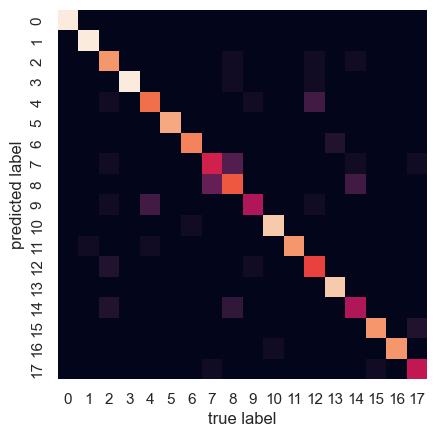

In [7]:
sns.heatmap(cm.T, square=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

#### Storing the Model

Lastly, the model is stored as a python object through pickle and used for the purposes of generating predictions for users based on their input on the MVP website.

In [10]:
rf_classifier_model = model.fit(X, y)
pickle.dump(rf_classifier_model, open('model.pkl','wb'))